In [1]:
import json
import numpy as np
import re
import os
import openai
import pandas as pd
import argparse
from dotenv import load_dotenv, find_dotenv

parser = argparse.ArgumentParser()

_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
current_directory = os.getcwd()

results_array_FF = np.load(os.path.join(current_directory, 'exp_data', "results_ug_FF.npy"))
reasons_array_FF = np.load(os.path.join(current_directory, 'exp_data', "reasons_ug_FF.npy"), allow_pickle=True)

results_array_SS = np.load(os.path.join(current_directory, 'exp_data', "results_ug_SS.npy"))
reasons_array_SS = np.load(os.path.join(current_directory, 'exp_data', "reasons_ug_SS.npy"), allow_pickle=True)

results_array_FS = np.load(os.path.join(current_directory, 'exp_data', "results_ug_FS.npy"))
reasons_array_FS = np.load(os.path.join(current_directory, 'exp_data', "reasons_ug_FS.npy"), allow_pickle=True)

results_array_SF = np.load(os.path.join(current_directory, 'exp_data', "results_ug_SF.npy"))
reasons_array_SF = np.load(os.path.join(current_directory, 'exp_data', "reasons_ug_SF.npy"), allow_pickle=True)

all_treat = ['FF', 'SS', 'FS', 'SF']
results_array = {'FF': results_array_FF, 'SS': results_array_SS, 'FS': results_array_FS, 'SF': results_array_SF}
reasons_array = {'FF': reasons_array_FF, 'SS': reasons_array_SS, 'FS': reasons_array_FS, 'SF': reasons_array_SF}

sum_of_money = 100
rounds_num = 5

colors = {'FF': 'blue', 'SS': 'red', 'FS': 'green', 'SF': 'black'}
names = {'FF': 'fair-fair (FF)', 'SS': 'selfish-selfish (SS)', 'FS': 'fair-selfish (FS)', 'SF': 'selfish-fair (SF)'}

print(len(results_array_FF))
print(len(results_array_SS))
print(len(results_array_FS))
print(len(results_array_SF))


# for each treatment, generate a dataframe with the following columns: round, offer, acceptance, reason for offer, reason for acceptance
import pandas as pd

def generate_df(treat):
    num_simulations, num_rounds, _ = results_array[treat].shape
    round_array = []
    offer_array = []
    acceptance_array = []
    reason_offer_array = []
    reason_acceptance_array = []
    
    for sim in range(num_simulations):
        for t in range(num_rounds):
            round_array.append(t+1)
            offer_array.append(results_array[treat][sim, t, 0])
            acceptance_array.append(results_array[treat][sim, t, 1])
            reason_offer_array.append(reasons_array[treat][sim, t, 0])
            reason_acceptance_array.append(reasons_array[treat][sim, t, 1])

    acceptance_array = np.array(acceptance_array)
    
    df = pd.DataFrame({'round': round_array, 'offer': offer_array, 'acceptance': acceptance_array, 'rejection': 1-acceptance_array, 'reason_proposer': reason_offer_array, 'reason_responder': reason_acceptance_array})
    return df

# if df_FF not exists, generate it
if not os.path.exists(os.path.join(current_directory, 'exp_data', 'df_FF.csv')):
    df_FF = generate_df('FF')
    df_FF.to_csv(os.path.join(current_directory, 'exp_data', 'df_FF.csv'))
    df_SS = generate_df('SS')
    df_SS.to_csv(os.path.join(current_directory, 'exp_data', 'df_SS.csv'))
    df_FS = generate_df('FS')
    df_FS.to_csv(os.path.join(current_directory, 'exp_data', 'df_FS.csv'))
    df_SF = generate_df('SF')
    df_SF.to_csv(os.path.join(current_directory, 'exp_data', 'df_SF.csv'))
    df_FF['treatment'] = 'FF'
    df_SS['treatment'] = 'SS'
    df_FS['treatment'] = 'FS'
    df_SF['treatment'] = 'SF'

    df_all = pd.concat([df_FF, df_SS, df_FS, df_SF])

    # create a new column to indicate whether the proposer and the responder are selfish or fair
    df_all['proposer_selfish'] = df_all['treatment'].apply(lambda x: 'selfish' if x == 'SS' or x == 'SF' else 'fair')
    df_all['responder_selfish'] = df_all['treatment'].apply(lambda x: 'selfish' if x == 'FS' or x == 'SS' else 'fair')

    # save df_all as a csv file
    df_all.to_csv(os.path.join(current_directory, 'exp_data', 'df_all.csv'))

else:
    print('Dataframes already exist')
    df_all = pd.read_csv(os.path.join(current_directory, 'exp_data', "df_all.csv"), index_col=0)
    df_FF = pd.read_csv(os.path.join(current_directory, 'exp_data', "df_FF.csv"), index_col=0)
    df_SS = pd.read_csv(os.path.join(current_directory, 'exp_data', "df_SS.csv"), index_col=0)
    df_FS = pd.read_csv(os.path.join(current_directory, 'exp_data', "df_FS.csv"), index_col=0)
    df_SF = pd.read_csv(os.path.join(current_directory, 'exp_data', "df_SF.csv"), index_col=0)

df_all

100
100
100
100
Dataframes already exist


,round,offer,acceptance,rejection,reason_proposer,reason_responder,treatment,proposer_selfish,responder_selfish,responder_text_accept_analysed,accept_get_payoff_responder,expect_better_future_responder,limited_rounds_responder,responder_text_reject_analysed_3,consistently_diminishing_offers_responder,potential_for_higher_future_offer_responder
0,1,45.0,1.0,0.0,"Since this is the first round, I have no infor...",The proposer's offer of 45 dollars is quite fa...,FF,fair,fair,False,NaN,NaN,NaN,False,NaN,NaN
1,2,40.0,1.0,0.0,"In the first round, the responder accepted a f...",While the offer of 40 dollars is less favorabl...,FF,fair,fair,False,NaN,NaN,NaN,False,NaN,NaN
2,3,35.0,1.0,0.0,The previous rounds suggest that the responder...,While the proposer's offers have been decreasi...,FF,fair,fair,False,NaN,NaN,NaN,False,NaN,NaN
3,4,32.0,1.0,0.0,The past three rounds show that the responder ...,The proposer has been progressively offering l...,FF,fair,fair,False,NaN,NaN,NaN,False,NaN,NaN
4,5,30.0,1.0,0.0,"In the previous rounds, the responder has cons...",Considering my objectives of maximizing payoff...,FF,fair,fair,True,1.0,0.0,1.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,40.0,1.0,0.0,I want to maximize my payoff while still offer...,The offer is below an equal split but still su...,SF,selfish,fair,False,NaN,NaN,NaN,False,NaN,NaN
1996,2,35.0,1.0,0.0,Since the responder accepted a 60-40 split in ...,"Accepting the offer, despite it being less fav...",SF,selfish,fair,False,NaN,NaN,NaN,False,NaN,NaN
1997,3,30.0,1.0,0.0,Since the responder accepted 35 dollars in the...,"The offer is progressively getting worse, but ...",SF,selfish,fair,True,1.0,1.0,0.0,False,NaN,NaN
1998,4,25.0,0.0,1.0,"The responder has accepted decreasing amounts,...",Accepting provides a guaranteed increase to my...,SF,selfish,fair,False,NaN,NaN,NaN,False,NaN,NaN


In [3]:
from scipy.stats import sem
from scipy import stats


def sep(binary_array):
    n = len(binary_array)
    p = np.sum(binary_array) / n
    se_proportion = np.sqrt(p * (1 - p) / n)
    return se_proportion

all_offers = {}
for treat in all_treat:
  all_offers[treat] = results_array[treat][:, :, 0].reshape(-1)

all_decs = {}
for treat in all_treat:
  all_decs[treat] = results_array[treat][:, :, 1].reshape(-1)

for treat in all_treat:
  print('====================')
  print(treat)
  print(f'mean offer: {np.mean(all_offers[treat]) } ({stats.sem(all_offers[treat])})')
  print(f'median offer: {np.median(all_offers[treat])}')
  print(f'mean rejection rate: {1-np.mean(all_decs[treat])} ({sep(all_decs[treat])})) ')
  print(f'p value of rejection rate compared to zero: {stats.ttest_1samp(all_decs[treat], 1)[1]}')
  print(f'median rejection rate: {1-np.median(all_decs[treat])}')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


FF
mean offer: 40.278 (0.26623146016344784)
median offer: 40.0
mean rejection rate: 0.04400000000000004 (0.009172131704244116)) 
p value of rejection rate compared to zero: 2.177976048147937e-06
median rejection rate: 0.0
SS
mean offer: 28.552 (0.3347337529600824)
median offer: 30.0
mean rejection rate: 0.050000000000000044 (0.00974679434480897)) 
p value of rejection rate compared to zero: 4.266586352634249e-07
median rejection rate: 0.0
FS
mean offer: 38.826 (0.3120933394114812)
median offer: 40.0
mean rejection rate: 0.006000000000000005 (0.0034536936748935927)) 
p value of rejection rate compared to zero: 0.0832638962248414
median rejection rate: 0.0
SF
mean offer: 30.94 (0.25947534547586526)
median offer: 30.0
mean rejection rate: 0.17800000000000005 (0.01710648999648964)) 
p value of rejection rate compared to zero: 4.831316410457942e-23
median rejection rate: 0.0


In [4]:
def change_off_res(big_array):
  '''
  Args:
    big_array: (num_simulations, num_rounds, 2)

  Returns:
    a dictionary with keys: COOAA, COOAR, ARAOI, ARAOD
    which represent the change of offer after acceptance, change of offer after rejection, acceptance rate after offer increase, acceptance rate after offer decrease
  '''

  num_simulations, num_rounds, _ = big_array.shape

  cooaa = []
  cooar = []
  araoi = []
  araod = []

  for sim in range(num_simulations):
    for t in range(4):
      off_last, dec_last = big_array[sim][t]
      off_cur, dec_cur = big_array[sim][t+1]

      if int(dec_last) == 1:
        cooaa.append(off_cur - off_last)
      elif int(dec_last) == 0:
        cooar.append(off_cur - off_last)

      if off_cur > off_last:
        araoi.append(dec_cur)
      elif off_cur < off_last:
        araod.append(dec_cur)


  return {'COOAA': np.array(cooaa), 'COOAR': np.array(cooar), 'ARAOI': np.array(araoi), 'ARAOD': np.array(araod)}

In [5]:
conditional_action = {}
for treat in all_treat:
  conditional_action[treat] = change_off_res(results_array[treat])

for treat in all_treat:
  print('=============')
  print(treat)
  print(f"Change of offer after acceptance: {np.mean(conditional_action[treat]['COOAA'])} ( {stats.sem(conditional_action[treat]['COOAA'])} )"   )
  print(f"Change of offer after rejection: {np.mean(conditional_action[treat]['COOAR'])} ( {stats.sem(conditional_action[treat]['COOAR'])} )"   )
  print(f"Rejection rate after offer increase: {1-np.mean(conditional_action[treat]['ARAOI'])} ( {sep(conditional_action[treat]['ARAOI'])} )"   )
  print(f"Rejection rate after offer decrease: {1-np.mean(conditional_action[treat]['ARAOD'])} ( {sep(conditional_action[treat]['ARAOD'])} )"   )

  # print the p-values
  print(f"p value Change of offer after acceptance: {stats.ttest_1samp(conditional_action[treat]['COOAA'], 0)[1]}")
  print(f"p value Change of offer after rejection: {stats.ttest_1samp(conditional_action[treat]['COOAR'], 0)[1]}")
  print(f"p value Rejection rate after offer increase: {stats.ttest_1samp(conditional_action[treat]['ARAOI'], 1)[1]}")
  print(f"p value Rejection rate after offer decrease: {stats.ttest_1samp(conditional_action[treat]['ARAOD'], 1)[1]}")

  # print number of observations
  print(f"Number of observations for Change of offer after acceptance: {len(conditional_action[treat]['COOAA'])}")
  print(f"Number of observations for Change of offer after rejection: {len(conditional_action[treat]['COOAR'])}")
  print(f"Number of observations for Rejection rate after offer increase: {len(conditional_action[treat]['ARAOI'])}")
  print(f"Number of observations for Rejection rate after offer decrease: {len(conditional_action[treat]['ARAOD'])}")




FF
Change of offer after acceptance: -0.8148148148148148 ( 0.16318920786323213 )
Change of offer after rejection: 7.590909090909091 ( 0.8442807100457596 )
Rejection rate after offer increase: 0.01904761904761909 ( 0.013339810542038612 )
Rejection rate after offer decrease: 0.16393442622950816 ( 0.033517787072174926 )
p value Change of offer after acceptance: 9.102404473819831e-07
p value Change of offer after rejection: 1.2058333792674179e-08
p value Rejection rate after offer increase: 0.15829022001914597
p value Rejection rate after offer decrease: 3.399332369798165e-06
Number of observations for Change of offer after acceptance: 378
Number of observations for Change of offer after rejection: 22
Number of observations for Rejection rate after offer increase: 105
Number of observations for Rejection rate after offer decrease: 122
SS
Change of offer after acceptance: -3.6773333333333333 ( 0.15815237430940743 )
Change of offer after rejection: 6.24 ( 0.6035450825470015 )
Rejection rate 

/var/folders/2b/1jfpbk6s1fl1h1jnnmr1vx1m0000gn/T/ipykernel_75501/3809461460.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(f"p value Rejection rate after offer increase: {stats.ttest_1samp(conditional_action[treat]['ARAOI'], 1)[1]}")


In [7]:
# print the num of rejections in round 1 and 5

for treat in all_treat:
    print(f'=============')
    print(treat)
    print(f'Number of rejections in round 1: {100-np.sum(results_array[treat][:, 0, 1])}')
    print(f'Number of rejections in round 5: {100-np.sum(results_array[treat][:, 4, 1])}')

FF
Number of rejections in round 1: 0.0
Number of rejections in round 5: 0.0
SS
Number of rejections in round 1: 1.0
Number of rejections in round 5: 0.0
FS
Number of rejections in round 1: 0.0
Number of rejections in round 5: 0.0
SF
Number of rejections in round 1: 1.0
Number of rejections in round 5: 1.0


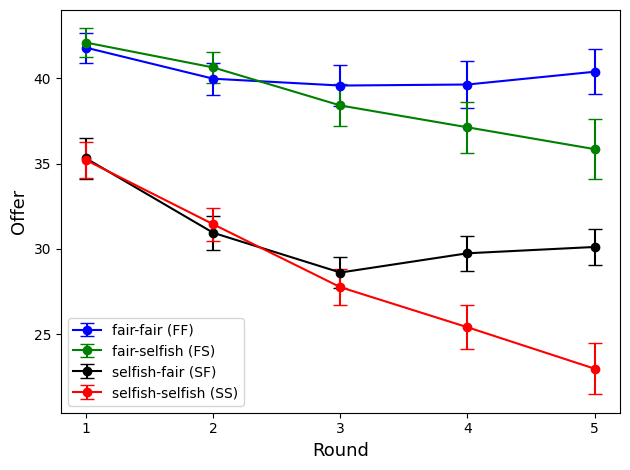

In [8]:
import matplotlib.pyplot as plt

all_treat = ['FF', 'FS', 'SF', 'SS']

for treat in all_treat:
  mean_offer = []
  se_offer = []
  for t in range(5):
    choice_rnd = results_array[treat][:, t, 0].reshape(-1)
    mean_offer.append(np.mean(choice_rnd) )
    se_offer.append( stats.sem(choice_rnd) )
    x = np.arange(1, 6)
  plt.errorbar(x, np.array(mean_offer), yerr= 1.96 * np.array(se_offer), fmt='-o', color=colors[treat], label=names[treat], capsize=5)


plt.xlabel('Round', fontsize = 13)
plt.ylabel('Offer', fontsize = 13)

plt.legend()
plt.xticks(np.arange(1, 6, step=1))
plt.tight_layout()
plt.savefig(os.path.join(current_directory, 'plots', 'offer_round.png'), dpi=150)
plt.show()

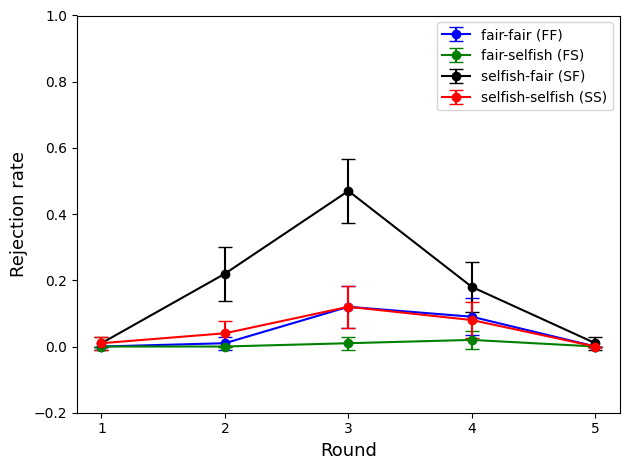

In [9]:
round_numbers = np.arange(1, 6)
fig, ax = plt.subplots()

for treat in all_treat:
  mean_act = []
  se_act = []
  for t in range(5):
    choice_rnd = results_array[treat][:, t, 1].reshape(-1)
    mean_act.append(np.mean(choice_rnd) )
    se_act.append( sep(choice_rnd) )
  ax.errorbar(round_numbers, 1-np.array(mean_act), yerr= 1.96 * np.array(se_act), fmt='o-', color=colors[treat], capsize=5, label=names[treat])


ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Rejection rate', fontsize=13)
ax.set_ylim(-0.2, 1)
ax.set_xticks(round_numbers)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(current_directory, 'plots', 'rejection_round.png'), dpi=150)
plt.show()

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd


# logit regression of rejection rate on offer, round, whether proposer is selfish, whether responder is selfish
logit_model = smf.logit(formula='rejection ~ offer + round + proposer_selfish + responder_selfish', data=df_all).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.176913
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              rejection   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.2989
Time:                        15:46:49   Log-Likelihood:                -353.83
converged:                       True   LL-Null:                       -504.69
Covariance Type:            nonrobust   LLR p-value:                 4.608e-64
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.6921      0.888      7.537      0.000

In [11]:
# OLS of offer on round, whether proposer is selfish, whether responder is selfish
ols_model = smf.ols(formula='offer ~ round + proposer_selfish + responder_selfish', data=df_all).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  offer   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     509.3
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.01e-245
Time:                        15:46:49   Log-Likelihood:                -6494.6
No. Observations:                2000   AIC:                         1.300e+04
Df Residuals:                    1996   BIC:                         1.302e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [12]:
# get the fraction of each category in the first two rounds and the last two rounds

category_list_accept_responder = ['accept_get_payoff', 'expect_better_future', 'limited_rounds']

print('====================')
print('first two rounds')

relavant_rows = df_all[(df_all['acceptance']==1) & (df_all['responder_text_accept_analysed'] & (df_all['round']<=2) & (df_all['offer']<=30))]
print(len(relavant_rows))
for feature in category_list_accept_responder:
    print(f'{feature}: {np.sum(relavant_rows[f"{feature}_responder"])/len(relavant_rows)}')
    

print('====================')
print('last two rounds')
relavant_rows = df_all[(df_all['acceptance']==1) & (df_all['responder_text_accept_analysed'] & (df_all['round']>=4) & (df_all['offer']<=30))]
print(len(relavant_rows))
for feature in category_list_accept_responder:
    print(f'{feature}: {np.sum(relavant_rows[f"{feature}_responder"])/len(relavant_rows)}')
    

first two rounds
158
accept_get_payoff: 1.0
expect_better_future: 0.6708860759493671
limited_rounds: 0.06962025316455696
last two rounds
322
accept_get_payoff: 1.0
expect_better_future: 0.11801242236024845
limited_rounds: 0.782608695652174


In [13]:
# get the fraction of each category in round 3

category_list_reject_responder_3 = ["consistently_diminishing_offers" , "potential_for_higher_future_offer"]
relavant_rows = df_all[(df_all['acceptance']==0) & (df_all['responder_text_reject_analysed_3'] & (df_all['round']==3))]
print(len(relavant_rows))

for feature in category_list_reject_responder_3:
    print(f'{feature}: {np.sum(relavant_rows[f"{feature}_responder"])/len(relavant_rows)}')
    

72
consistently_diminishing_offers: 0.8333333333333334
potential_for_higher_future_offer: 1.0


In [14]:
from scipy.stats import wilcoxon

# compare the offer and rejection rate between each pair of treatments, Wilcoxon signed-rank test
for treat1, treat2 in [('FF', 'SS'), ('FF', 'FS'), ('FF', 'SF'), ('SS', 'FS'), ('SS', 'SF'), ('FS', 'SF')]:
    print(f'====================')
    print(f'{treat1} vs {treat2}')
    print(f'offer: {wilcoxon(df_all[df_all["treatment"]==treat1]["offer"], df_all[df_all["treatment"]==treat2]["offer"])}')
    print(f'rejection rate: {wilcoxon(df_all[df_all["treatment"]==treat1]["rejection"], df_all[df_all["treatment"]==treat2]["rejection"])}')


FF vs SS
offer: WilcoxonResult(statistic=1416.0, pvalue=6.153669591257953e-68)
rejection rate: WilcoxonResult(statistic=360.0, pvalue=0.6309540411841708)
FF vs FS
offer: WilcoxonResult(statistic=23473.5, pvalue=0.0009706226055810708)
rejection rate: WilcoxonResult(statistic=39.0, pvalue=0.00014469608785023995)
FF vs SF
offer: WilcoxonResult(statistic=2988.0, pvalue=2.9444497207778974e-62)
rejection rate: WilcoxonResult(statistic=672.0, pvalue=6.24021484679824e-12)
SS vs FS
offer: WilcoxonResult(statistic=2049.5, pvalue=2.390994073450023e-66)
rejection rate: WilcoxonResult(statistic=43.5, pvalue=3.215955563200678e-05)
SS vs SF
offer: WilcoxonResult(statistic=21914.0, pvalue=4.876639163387692e-09)
rejection rate: WilcoxonResult(statistic=776.0, pvalue=6.490901215801131e-11)
FS vs SF
offer: WilcoxonResult(statistic=6693.0, pvalue=3.429157670126327e-50)
rejection rate: WilcoxonResult(statistic=91.0, pvalue=1.2438047633009495e-19)
